#Model Building Using Text Analysis

In [11]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
sns.set_style("whitegrid")
sns.set_context("poster")
import nltk
from sklearn.feature_extraction.text import CountVectorizer

In [12]:
critics = pd.read_csv('comments1_with_sentiments.csv')
#let's drop rows with missing quotes
critics['positive'] = critics['Answer1'] >= 0
critics.head()

,HITID,index,body,company,date,score,Worker1,Answer1,Avg,Date,positive
0,3L21G7IH4773YI2L6RV6T5G4RTC1YW,1199,"I shall do that! I was thinking ""I've had this...",Fitbit,1449270750,3,A2R0YYUAWNT7UD,2,2,2015-12-05 06:58:53 UTC,True
1,3I7KR83SNAOQ3IGZ6P98Z3JCRQR9KI,1178,Love it. Has helped keep me on track for weigh...,Fitbit,1449265917,2,A1NM7ZPZ3NH412,2,2,2015-12-05 06:59:05 UTC,True
2,3P7RGTLO6EO481Q4YVN8VYUWX89KA8,1174,I love it because I do not have to stop and pu...,Fitbit,1449251995,2,A3ITZNJQUTIZ4C,2,2,2015-12-05 07:02:17 UTC,True
3,373L46LKP7HF9UT8S10LOXXFNV3KJO,409,"I never wore a watch, now I wear an Apple Watc...",Apple,1449290608,1,A2R0YYUAWNT7UD,2,2,2015-12-05 06:59:32 UTC,True
4,3G9UA71JVV5REFMO97BCKSSTHB2J7G,1465,"The fallout soundtracks are great, but IMO the...",Spotify,1449249457,1,A1FP3SH704X01V,2,2,2015-12-05 06:59:41 UTC,True


In [15]:
grp = critics.groupby('company')
avg = grp.Answer1.sum()

(array([   36.,     0.,   359.,     0.,     0.,  1127.,     0.,   303.,
            0.,    21.]),
 array([-2. , -1.6, -1.2, -0.8, -0.4,  0. ,  0.4,  0.8,  1.2,  1.6,  2. ]),
 <a list of 10 Patch objects>)

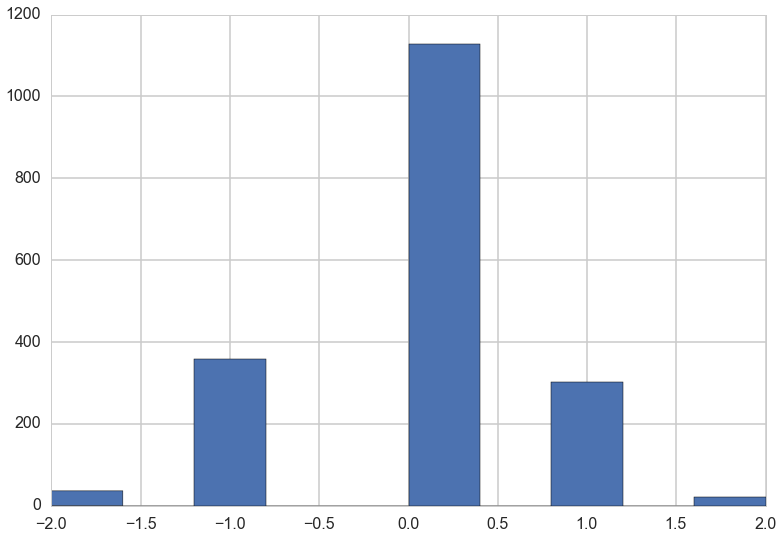

In [252]:
plt.hist(critics['Answer1'])

(array([  1.79900000e+03,   3.70000000e+01,   3.00000000e+00,
          4.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([ -71.,   32.,  135.,  238.,  341.,  444.,  547.,  650.,  753.,
         856.,  959.]),
 <a list of 10 Patch objects>)

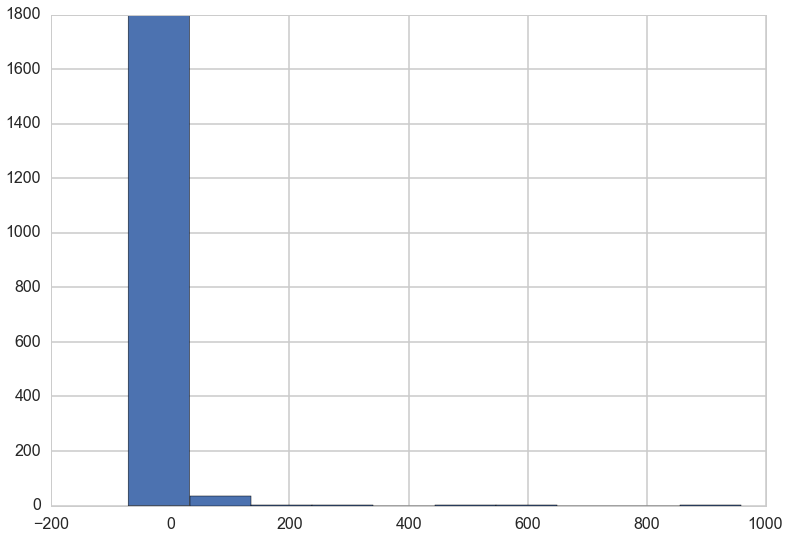

In [253]:
plt.hist(critics['score'])

#Validation Tools

In [272]:
def make_xy(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer(encoding = 'utf-8', strip_accents = 'ascii', stop_words='english')
    X = vectorizer.fit_transform(critics.body)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.Answer1).values.astype(np.int)
    return X, y


def make_xyBinary(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer(encoding = 'utf-8', strip_accents = 'ascii', stop_words='english')
    X = vectorizer.fit_transform(critics.body)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.positive).values.astype(np.int)
    return X, y
X, y = make_xy(critics)
Xbin, ybin = make_xyBinary(critics)

In [273]:
#train/test split the data
xtrain, xtest, ytrain, ytest = train_test_split(X, y)
xbintrain, xbintest, ybintrain, ybintest = train_test_split(Xbin, ybin)

In [ ]:
from sklearn.cross_validation import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(y.size, nfold): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

In [ ]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y < 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

In [ ]:
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(critics.shape[0]), train_size=0.7)
mask=np.ones(critics.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

#Model Building Time

##MultiNomial Naive Bayes

In [284]:
#Multinomail Naive Bayes
clf = MultinomialNB()
clf = clf.fit(xtrain, ytrain)
training_accuracy = clf.score(xtrain, ytrain)
print "Naive Bayes"
print "Accuracy on training data: %0.2f" % (training_accuracy)
print "MN Accuracy: %0.2f%%" % (100 * clf.score(xtest, ytest))

clfbin = MultinomialNB()
clfbin = clfbin.fit(xbintrain, ybintrain)
training_accuracy = clfbin.score(xbintrain, ybintrain)
print "Naive Bayes Binary"
print "Accuracy on training data: %0.2f" % (training_accuracy)
print "MN Accuracy: %0.2f%%" % (100 * clfbin.score(xbintest, ybintest))

Naive Bayes
Accuracy on training data: 0.88
MN Accuracy: 54.98%
Naive Bayes Binary
Accuracy on training data: 0.95
MN Accuracy: 72.08%


In [285]:
def validation(clf, binary= False):
    alphas = [0, .1, 1, 5, 10, 50]
    min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

    #Find the best value for alpha and min_df, and the best classifier
    best_alpha = None
    best_min_df = None
    maxscore=-np.inf
    for alpha in alphas:
        for min_df in min_dfs:         
            vectorizer = CountVectorizer(min_df = min_df)
            if not binary:
                Xthis, ythis = make_xy(critics, vectorizer)
            else:
                Xthis, ythis = make_xyBinary(critics,vectorizer)
            Xtrainthis=Xthis[mask]
            ytrainthis=ythis[mask]
            #your code here
            clf = MultinomialNB(alpha=alpha)
            cvscore = cv_score(clf, Xtrainthis, ytrainthis, log_likelihood)

            if cvscore > maxscore:
                maxscore = cvscore
                best_alpha, best_min_df = alpha, min_df
    return best_alpha, best_min_df
best_alpha1, best_min_df1 = validation(clf)
best_alpha2, best_min_df2 = validation(clf, binary = True)

In [292]:
vectorizer = CountVectorizer(min_df=best_min_df1)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha1).fit(xtrain, ytrain)

vectorizerbin = CountVectorizer(min_df=best_min_df2)
X, y = make_xyBinary(critics, vectorizer)
xbintrain=X[mask]
ybintrain=y[mask]
xbintest=X[~mask]
ybintest=y[~mask]

clfbin = MultinomialNB(alpha=best_alpha2).fit(xbintrain, ybintrain)

# Your code here. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print "Parameter Optimized Naive Bayes"
print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on test data:     %0.2f" % (test_accuracy)

training_accuracybin = clfbin.score(xbintrain, ybintrain)
test_accuracybin = clfbin.score(xbintest, ybintest)

print "Parameter Optimized Naive Bayes"
print "Accuracy on training data: %0.2f" % (training_accuracybin)
print "Accuracy on test data:     %0.2f" % (test_accuracybin)



Parameter Optimized Naive Bayes
Accuracy on training data: 0.62
Accuracy on test data:     0.59
Parameter Optimized Naive Bayes
Accuracy on training data: 0.80
Accuracy on test data:     0.75


##Random Forest

In [300]:
#Random Forest
rf = RandomForestClassifier(n_estimators=100, min_samples_split=2, n_jobs=-1).fit(xtrain,ytrain)
rf_train_accuracy = rf.score(xtrain, ytrain)
print "Random Forest with Ranges"
print "Accuracy on training data: %0.2f" % (rf_train_accuracy)
print "RF Accuracy: %.02f%%" % (100*rf.score(xtest,ytest))

rfbin = RandomForestClassifier(n_estimators=100, min_samples_split=2, n_jobs=-1).fit(xbintrain,ybintrain)
rfbin_train_accuracy = rfbin.score(xbintrain, ybintrain)
print "Random Forest Binary Data"
print "Accuracy on training data: %0.2f" % (rfbin_train_accuracy)
print "RF Accuracy: %.02f%%" % (100*rfbin.score(xbintest,ybintest))

Random Forest with Ranges
Accuracy on training data: 0.94
RF Accuracy: 58.48%
Random Forest Binary Data
Accuracy on training data: 0.98
RF Accuracy: 73.65%


In [250]:
n_ests = [10, 20, 50, 100, 150, 200]
min_dfs = [0,.1,.01,.001,.0001,1]
max_depths = [5,10,15,20,25,40,50,70,80,90]

#Find the best value for alpha and min_df, and the best classifier
best_n_est = 10
# n_est = range(best_n_est-5, best_n_est+5)
# min_dfs = range(int(best_min_df), int(best_min_df+5.))
# max_depths = range(max_depth-5, max_depth+5)

# best_n_est = n_est[0]
maxscore=-np.inf
for max_depth in max_depths:
    for n_est in n_ests:  
        for min_df in min_dfs:
            vectorizer = CountVectorizer(min_df = min_df)       
            Xthis, ythis = make_xy(critics, vectorizer)
            Xtrainthis=Xthis[mask]
            ytrainthis=ythis[mask]
            #your code here
            rf = RandomForestClassifier(n_estimators=n_est,max_depth = max_depth, min_samples_split=2, n_jobs=-1)
            cvscore = cv_score(rf, Xtrainthis, ytrainthis, log_likelihood)

            if cvscore > maxscore:
                maxscore = cvscore
                best_n_est, best_min_df, best_max_depth = n_est, min_df, max_depth

In [290]:
vectorizer = CountVectorizer(min_df=best_min_df)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

best_rf = RandomForestClassifier(n_estimators=best_n_est, min_samples_split=2, n_jobs=-1).fit(xtrain,ytrain)
rf_train_accuracy = best_rf.score(xtrain, ytrain)
rf_test_accuracy = best_rf.score(xtest, ytest)

print "Accuracy on training data: %0.2f" % (rf_train_accuracy)
print "Accuracy on test %0.2f" % (rf_test_accuracy)

Accuracy on training data: 0.93
Accuracy on test 0.53


In [295]:
#Logistic Regression
logistic = LogisticRegression(penalty="l1").fit(xbintrain, ybintrain)
log_train_accuracy = logistic.score(xbintrain,ybintrain)
print "Logistic Regression"
print "Accuracy on training data: %0.2f" % (log_train_accuracy)
print "Logistic Accuracy: %.02f%%" % (100*logistic.score(xbintest,ybintest))

Logistic Regression
Accuracy on training data: 0.80
Logistic Accuracy: 75.99%


#Visualization of the Results

In [276]:
def calibration_plot(clf, xtest, ytest):
    prob = clf.predict_proba(xtest)[:, 1]
    outcome = ytest
    data = pd.DataFrame(dict(prob=prob, outcome=outcome))

    #group outcomes into bins of similar probability
    bins = np.linspace(0, 1, 20)
    cuts = pd.cut(prob, bins)
    binwidth = bins[1] - bins[0]
    
    #freshness ratio and number of examples in each bin
    cal = data.groupby(cuts).outcome.agg(['mean', 'count'])
    cal['pmid'] = (bins[:-1] + bins[1:]) / 2
    cal['sig'] = np.sqrt(cal.pmid * (1 - cal.pmid) / cal['count'])
        
    #the calibration plot
    ax = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    p = plt.errorbar(cal.pmid, cal['mean'], cal['sig'])
    plt.plot(cal.pmid, cal.pmid, linestyle='--', lw=1, color='k')
    plt.ylabel("Empirical P(Fresh)")
    
    #the distribution of P(fresh)
    ax = plt.subplot2grid((3, 1), (2, 0), sharex=ax)
    
    plt.bar(left=cal.pmid - binwidth / 2, height=cal['count'],
            width=.95 * (bins[1] - bins[0]),
            fc=p[0].get_color())
    
    plt.xlabel("Predicted P(Fresh)")
    plt.ylabel("Number")

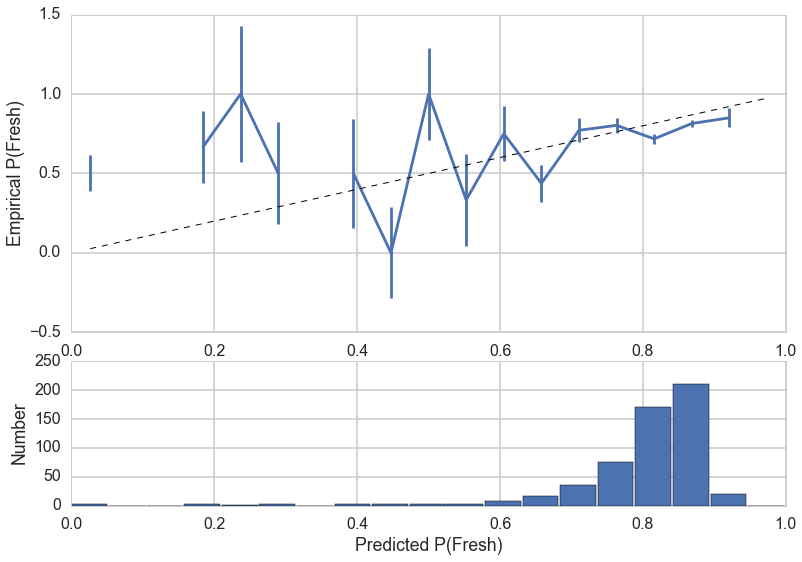

In [296]:
calibration_plot(logistic, xbintest, ybintest)

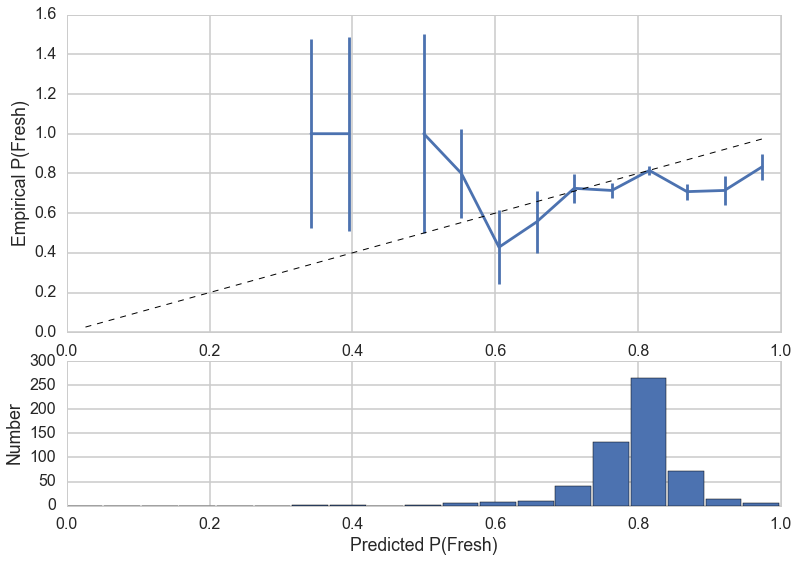

In [297]:
calibration_plot(clfbin, xbintest, ybintest)

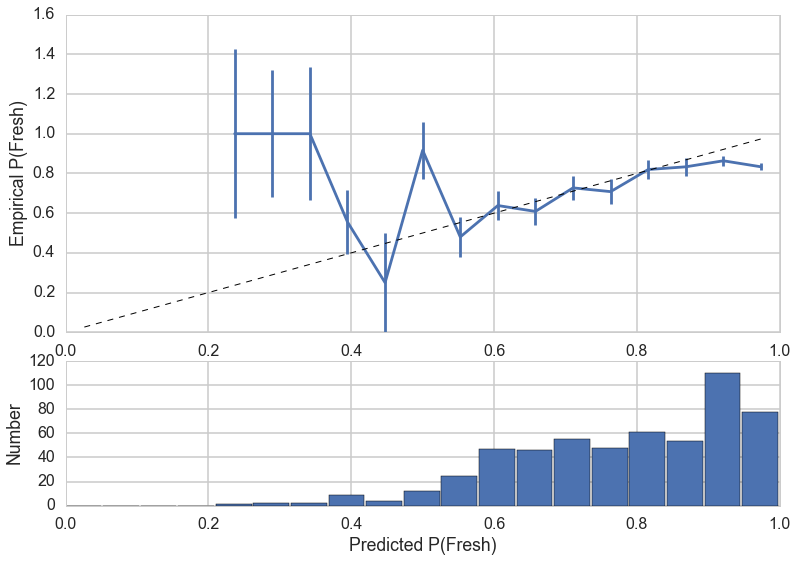

In [302]:
calibration_plot(rfbin, xbintest, ybintest)

#Random NLTK Sentiment

In [13]:
reddit = []
for row in range(len(critics.body)):
    words = critics.iloc[row].body.split()
    temp = (words, critics.iloc[row].Answer1)
    reddit.append(temp)

    

In [29]:
import nltk
def get_words_in_tweets(tweets):
    all_words = []
    for (words, sentiment) in tweets:
        all_words.extend(words)
    return all_words
def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    word_features = wordlist.keys()
    return word_features


In [30]:
word_features = get_word_features(get_words_in_tweets(reddit))

In [31]:
def extract_features(document):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['contains(%s)' % word] = (word in document_words)
    return features

In [32]:
training_set = nltk.classify.apply_features(extract_features, reddit)

In [33]:
classifier = nltk.NaiveBayesClassifier.train(training_set)

In [34]:
print 'accuracy:', nltk.classify.util.accuracy(classifier, training_set)
classifier.show_most_informative_features()

accuracy: 0.755687973998
Most Informative Features
        contains(great,) = True                2 : 0      =     85.5 : 1.0
      contains(awesome.) = True                2 : 0      =     51.3 : 1.0
      contains(Spotify.) = True                2 : 0      =     51.3 : 1.0
     contains(painfully) = True                2 : 0      =     51.3 : 1.0
       contains(Really?) = True                2 : 0      =     51.3 : 1.0
       contains(tracker) = True                2 : 0      =     51.3 : 1.0
           contains(Has) = True                2 : 0      =     51.3 : 1.0
           contains(us,) = True                2 : 0      =     51.3 : 1.0
           contains(IMO) = True                2 : 0      =     51.3 : 1.0
          contains(far.) = True                2 : 0      =     51.3 : 1.0


In [3]:
nltk.download()

showing info http://www.nltk.org/nltk_data/


True

In [15]:
import nltk

In [18]:
test = []
for (a,b) in reddit:
    test.append(nltk.pos_tag(a))

In [22]:
for a in test:
    print nltk.ne_chunk(a)

(S
  I/PRP
  shall/VBP
  do/VBP
  that!/-NONE-
  I/PRP
  was/VBD
  thinking/VBG
  "I've/JJ
  had/NN
  this/DT
  thing/NN
  forever,/NN
  there's/VBZ
  no/DT
  way/NN
  they'd/JJ
  cover/NN
  it"/NN
  but/CC
  I/PRP
  dug/VBP
  up/RP
  my/PRP$
  purchase/NN
  information/NN
  and/CC
  it/PRP
  turns/VBZ
  out/RP
  I'm/JJ
  just/RB
  within/IN
  the/DT
  one/CD
  year/NN
  warranty,/-NONE-
  so/RB
  I'm/JJ
  going/VBG
  to/TO
  contact/VB
  them,/JJ
  thanks!/NN
  Edit:/NN
  The/DT
  customer/NN
  service/NN
  rep/NN
  I/PRP
  got/VBD
  is/VBZ
  painfully/RB
  slow,/-NONE-
  but/CC
  very/RB
  helpful,/JJ
  and/CC
  a/DT
  replacement/NN
  is/VBZ
  on/IN
  the/DT
  way!/NNP
  :D/NNP
  Hooray/NNP
  Fitbit!/NNP)
(S
  (PERSON Love/NNP)
  it./NNP
  Has/NNP
  helped/VBD
  keep/VB
  me/PRP
  on/IN
  track/NN
  for/IN
  weight/NN
  loss./NNP)
(S
  I/PRP
  love/VBP
  it/PRP
  because/IN
  I/PRP
  do/VBP
  not/RB
  have/VB
  to/TO
  stop/VB
  and/CC
  put/VB
  my/PRP$
  weight/NN
  in/IN
  my/PRP

In [25]:
def tag_sentence(self, sentence, tag_with_lemmas=False):
        """
        the result is only one tagging of all the possible ones.
        The resulting tagging is determined by these two priority rules:
            - longest matches have higher priority
            - search is made from left to right
        """
        tag_sentence = []
        N = len(sentence)
        if self.max_key_size == 0:
            self.max_key_size = N
        i = 0
        while (i < N):
            j = min(i + self.max_key_size, N) #avoid overflow
            tagged = False
            while (j > i):
                expression_form = ' '.join([word[0] for word in sentence[i:j]]).lower()
                expression_lemma = ' '.join([word[1] for word in sentence[i:j]]).lower()
                if tag_with_lemmas:
                    literal = expression_lemma
                else:
                    literal = expression_form
                if literal in self.dictionary:
                    #self.logger.debug("found: %s" % literal)
                    is_single_token = j - i == 1
                    original_position = i
                    i = j
                    taggings = [tag for tag in self.dictionary[literal]]
                    tagged_expression = (expression_form, expression_lemma, taggings)
                    if is_single_token: #if the tagged literal is a single token, conserve its previous taggings:
                        original_token_tagging = sentence[original_position][2]
                        tagged_expression[2].extend(original_token_tagging)
                    tag_sentence.append(tagged_expression)
                    tagged = True
                else:
                    j = j - 1
            if not tagged:
                tag_sentence.append(sentence[i])
                i += 1
        return tag_sentence

In [26]:
def tag(self, postagged_sentences):
        return [self.tag_sentence(sentence) for sentence in postagged_sentences]

In [28]:
class DictionaryTagger(object):
    def __init__(self, dictionary_paths):
        files = [open(path, 'r') for path in dictionary_paths]
        dictionaries = [yaml.load(dict_file) for dict_file in files]
        map(lambda x: x.close(), files)
        self.dictionary = {}
        self.max_key_size = 0
        for curr_dict in dictionaries:
            for key in curr_dict:
                if key in self.dictionary:
                    self.dictionary[key].extend(curr_dict[key])
                else:
                    self.dictionary[key] = curr_dict[key]
                    self.max_key_size = max(self.max_key_size, len(key))

dicttagger = DictionaryTagger([ 'dicts/positive.yml', 'dicts/negative.yml'])

IOError: [Errno 2] No such file or directory: 'dicts/positive.yml'